In [1]:
import sys
import os
from deepface import DeepFace
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
print(sys.version)
print(np.__version__)
print(tf.__version__)

3.10.15 | packaged by Anaconda, Inc. | (main, Oct  3 2024, 07:22:19) [MSC v.1929 64 bit (AMD64)]
1.26.4
2.10.1


In [2]:
def extract_pixels_from_image(image: np.ndarray, facial_area: dict) -> np.ndarray:
    """
    Extrae el área de la imagen basado en las coordenadas de 'facial_area' y devuelve
    el recorte como un array en formato float64.

    Args:
        image (np.ndarray): Imagen original cargada con OpenCV en formato uint8 BGR.
        facial_area (dict): Diccionario con las coordenadas 'x', 'y', 'w', 'h'.

    Returns:
        np.ndarray: El recorte del rostro en formato float64 y en el rango [0, 1].
    """
    x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']
    
    # Ajustar las coordenadas para evitar índices negativos
    x = max(0, x)
    y = max(0, y)
    
    # Recortar la imagen en la región del área facial
    face_crop = image[y:y+h, x:x+w]

    # Convertir el recorte a float64 y escalar a [0, 1]
    face_crop_float64 = face_crop.astype(np.float64) / 255.0
    
    return face_crop_float64

def extract_and_expand_faces(img_path: str, margin_ratio: float = 0.0) -> list:
    """
    Extrae rostros de una imagen y expande los bounding boxes según el margin_ratio.
    Args:
        img_path (str): Ruta de la imagen para procesar.
        margin_ratio (float): Proporción de expansión del bounding box. 
    Returns:
        List[Dict[str, Any]]: Lista de rostros detectados con bounding boxes ajustados.
    """
    # Cargar la imagen
    image = cv2.imread(img_path)

    # Detectar rostros con DeepFace usando el modelo RetinaFace
    faces = DeepFace.extract_faces(
        img_path=image,
        detector_backend='retinaface',
        enforce_detection=False
    )

    # Expande los bounding boxes
    for face_data in faces:
        facial_area = face_data['facial_area']
        
        # Obtener coordenadas originales
        x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']
        
        # Calcular margen adicional basado en el ratio
        margin_x = int(w * margin_ratio)
        margin_y = int(h * margin_ratio)
        
        # Expande el bounding box con el margen calculado
        facial_area['x'] = x - margin_x
        facial_area['y'] = y - margin_y
        facial_area['w'] = w + 2 * margin_x
        facial_area['h'] = h + 2 * margin_y

    for __face__ in faces:
        __face__['face'] = extract_pixels_from_image(image, __face__['facial_area'])
    
    return faces

def get_img_array_uint8(arraydata):
    img = arraydata
    #B, G, R = img.T
    #__bgr_img = np.array((B, G, R)).T
    #bgr_img = (__bgr_img*255).astype(np.uint8)
    bgr_img = (img*255).astype(np.uint8)
    return bgr_img


Extracting faces...
Extracting reference face...
Comparing images...
100.000%

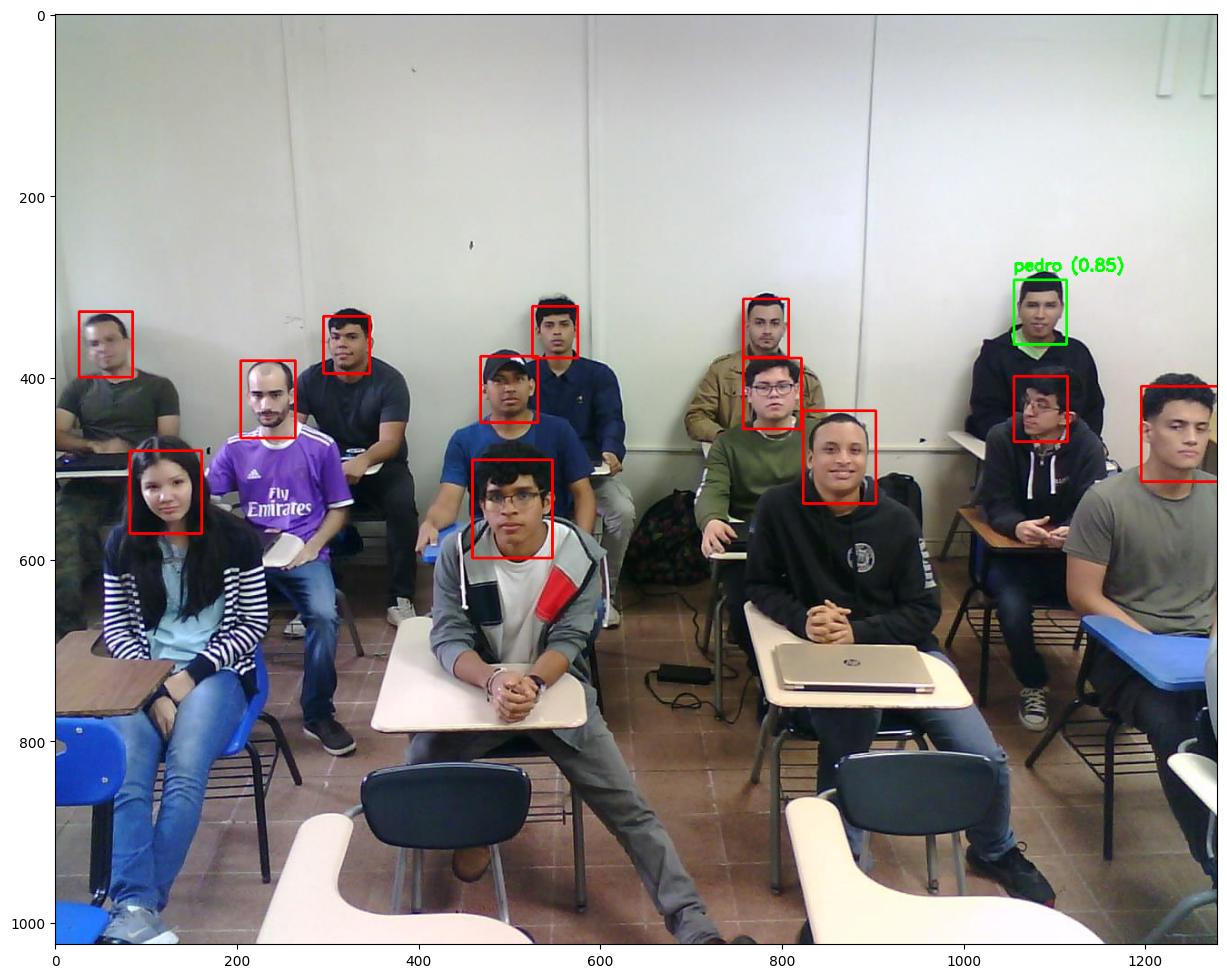

Index: 9 Distance: 0.1541
Index: 4 Distance: 0.4812
Index: 5 Distance: 0.5390
Index: 0 Distance: 0.5444
Index: 2 Distance: 0.5776
Index: 10 Distance: 0.5976
Index: 12 Distance: 0.6577
Index: 7 Distance: 0.6970
Index: 3 Distance: 0.7608
Index: 1 Distance: 0.7732
Index: 8 Distance: 0.8515
Index: 11 Distance: 0.9793
Index: 6 Distance: 1.0221


In [10]:
metrics = ["cosine", "euclidean", "euclidean_l2"]
models = ["Facenet", "Facenet512", "VGG-Face", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace","GhostFaceNet"]

# Cargar la imagen a analizar
image = cv2.imread("./data/classroom/rawdata/s2/recording_2024-11-13_10-45-09/frame-202.jpg")

#extraer los rostros de la imagen a analizar
print("Extracting faces...")
faces = extract_and_expand_faces("./data/classroom/rawdata/s2/recording_2024-11-13_10-45-09/frame-202.jpg", 0.2)

#extraer el rostro objetivo (face_target) de la imagen de referencia
print("Extracting reference face...")
target_face_data =  extract_and_expand_faces("./data/classroom/ref/sanchez-kendrick/img-00.png", 0.18)
name_person = "pedro"

# Inicializar la lista para almacenar los resultados
results = []

print("Comparing images...")
# Asegurarse de que se detectó el rostro objetivo
if len(target_face_data) > 0:
    target_face = target_face_data[0]['face']  # Obtener el rostro objetivo

    bgr_target_face = (target_face*255.0).astype(np.uint8)
    
    total_faces:int = len(faces)
    i:int = 0
    #iterar sobre cada rostro detectado en la imagen
    for face_data in faces:

        loading = str.format("{0:.3f}", ((i+0.0)/(0.0+total_faces-1.0))*100.0)
        print("\r" + loading + "%", end="")
        
        facial_area = face_data['facial_area']  #Obtener el area facial (bounding box)
        face = face_data['face']  #Obtener el rostro extraido
        bgr_face = (face*255.0).astype(np.uint8)
        
        # Realizar la comparación (verificación) entre el rostro detectado y el rostro objetivo
        result = DeepFace.verify(
            img1_path=bgr_target_face,
            img2_path=bgr_face,
            detector_backend="skip",  #omitir la deteccion ya que estan los rostros
            model_name="Facenet512",
            distance_metric="cosine",
            threshold=0.44,
            enforce_detection=True
        )

        results.append([i, result['distance'], result['threshold'], 'cosine'])
        
        #si coinciden (verified=True), dibujar un rectángulo verde, sino, dibujar uno rojo
        x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']
        if result['verified']:
            color = (0, 255, 0)  # Verde
            name = name_person  # Nombre del estudiante objetivo
            confidence = 1.0-result.get('distance', 0)
            label = f"{name} ({confidence:.2f})"  # Nombre y confianza
            cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        else:
            color = (0, 0, 255)  # Rojo
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        
        i += 1

    results.sort(key=lambda x: x[1])
    
    #convertir la imagen de BGR a RGB para visualizarla con Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    #Mostrar la imagen con los recuadros
    plt.figure(figsize=(15, 15))
    plt.imshow(image_rgb)
    plt.axis(True)
    plt.show()
    
    for res in results:
        print(f"Index: {res[0]} Distance: {res[1]:.4f}")
    
else:
    print("The target face was not detected.")